<a href="https://colab.research.google.com/github/AhmadMugiar/WEB_SCRAPPING_KP/blob/main/Sentimen_Analisis_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORT LIBRARY

In [18]:
!pip install transformers==4.28.0

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid',font_scale=1.2)
sns.set_palette(sns.color_palette("rocket"))

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from collections import defaultdict

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Let's start by defining some key variables that will be used later on in the training/evaluation process
RANDOM_SEED = 50
BATCH_SIZE = 16 # Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.
# Set seed for reproducibility.
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Load Data

In [21]:
df_reviews = pd.read_csv("/content/Scrapping_Clean_PosPay.csv")
df_reviews

,reviewId,userName,rate,reviews_text,tanggal reviews
0,4f702a1f-ea79-4903-9ad8-0ffbb346d548,pengguna google,1,mau masuk akun susah nya minta ampun..data bar...,2025-08-06
1,9a12b861-bfab-4401-86a4-932f66de8e8f,pengguna google,1,aplikasi rusak. cuma mentok di menu awal doang...,2025-08-06
2,06f4ca89-5bce-4f61-805e-954bab0b6058,pengguna google,5,mudah mengaksesnya,2025-08-06
3,4afc42dc-7a69-496f-9ce0-9f4c50f97c3b,pengguna google,1,"aplikasi cacat, proses pendaftarannya sangat b...",2025-08-05
4,6475b3ae-60e4-44bc-9652-cadb5efef0a2,pengguna google,5,mantap dan dan terbukti,2025-08-05
...,...,...,...,...,...
24855,8df6ec3f-e17b-4880-ad17-39ea29c558d8,pengguna google,5,sippp....,2019-04-12
24856,8e644416-def5-42cd-90ad-22e6a93e3072,pengguna google,5,bagus aplikasinya,2019-04-12
24857,3153c402-9175-4f65-b041-a13cb3dbc39c,pengguna google,5,good good,2019-04-12
24858,42c2883b-7808-469f-8463-bfac22699958,pengguna google,5,mantap. bagus aplikasinya. user friendly. ga r...,2019-04-12


In [22]:
df_reviews.isnull().sum()

,0
reviewId,0
userName,0
rate,0
reviews_text,0
tanggal reviews,0


In [23]:
df_reviews.drop('reviewId',axis=1,inplace=True)

In [24]:
df_reviews.shape

(24860, 4)

In [25]:
def draw_percentage(ax,total=float(len(df_reviews))):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2.
        y = p.get_height()
        ax.annotate(percentage, (x, y),ha='center',va='bottom')

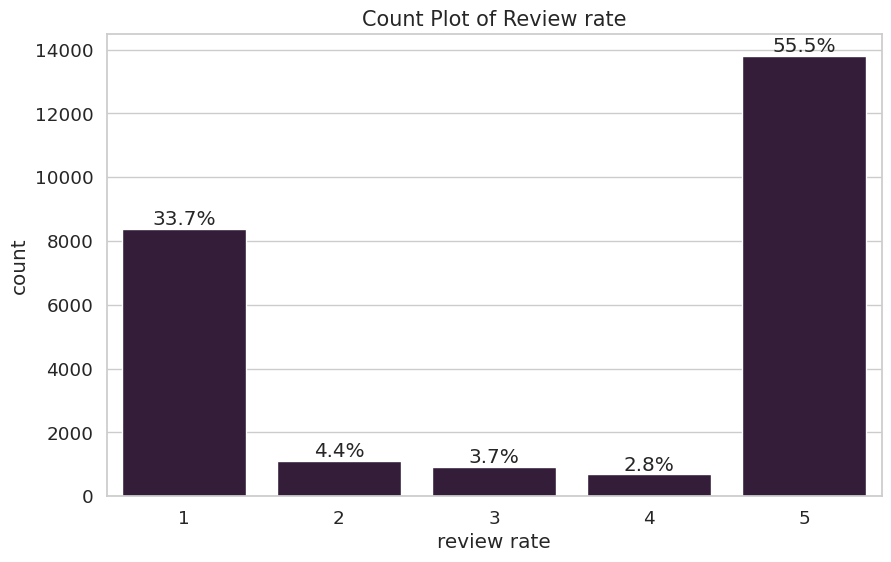

In [26]:
plt.figure(figsize = (10,6))
total = float(len(df_reviews))
ax = sns.countplot(x = 'rate',data=df_reviews)
plt.title('Count Plot of Review rate', fontsize=15)
plt.xlabel('review rate')
draw_percentage(ax)
plt.show()


In [28]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df_reviews['sentiment'] = df_reviews.rate.apply(to_sentiment)

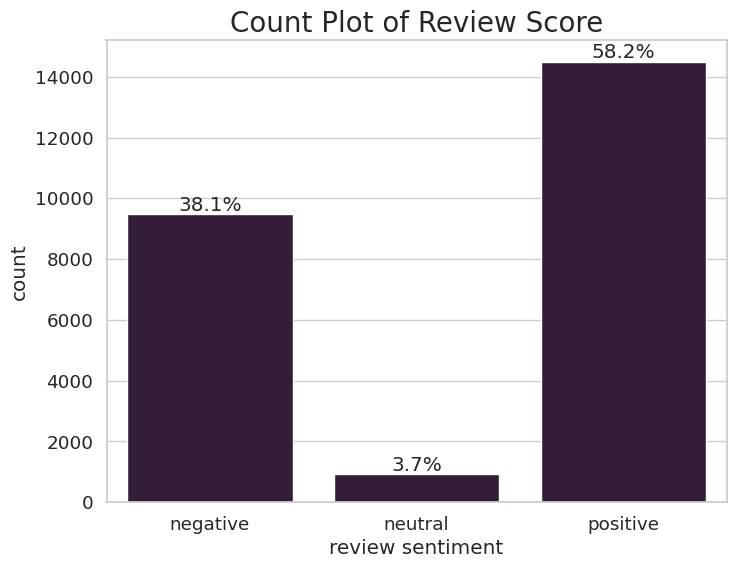

In [29]:
plt.figure(figsize = (8,6))
total = float(len(df_reviews))
ax = sns.countplot(x = 'sentiment',data=df_reviews)
class_names = ['negative', 'neutral', 'positive']
ax.set_xticklabels(class_names)
plt.title('Count Plot of Review Score', fontsize=20)
plt.xlabel('review sentiment')
draw_percentage(ax)

plt.show()

In [30]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [31]:
sample_txt = "we love you"

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: we love you
   Tokens: ['we', 'love', 'you']
Token IDs: [1195, 1567, 1128]
